## Домашнее задание

Обучить нейронную сеть для предсказания предела текучести (0.2% Proof Stress (MPa)) сталей на основании состава и температуры. Для этого подобрать наилучшим образом ее гиперпаметры (количество слоев, количество нейронов в слое, функции активации) построить зависимость предсказанного от реального значения и рассчитать ошибку (всё для обучающей и тестовой выборок). Сравнить точность с ранее обученными моделями

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
from torch import nn
import torch.nn.functional as F
from torchmetrics.regression import MeanSquaredError, R2Score

import lightning.pytorch as pl
from torchmetrics.functional import accuracy
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
df = pd.read_csv('./Steels_kaggle.csv')

Преобразуем данные в специальные датасеты для генерации батчей

In [6]:
class SimpleDataset():
    """
    Простой итерируемый датасет.
    """
    def __init__(self, X_data, y_data):
        assert len(X_data) == len(y_data)
        self.x = X_data
        self.y = y_data


    def __len__(self):
        """
        Размер датасета.
        """
        return len(self.y)

    def __getitem__(self, idx):
        """
        Обращение к элементу датасета по индексу.
        """
        xi = self.x[idx].ravel().astype(np.float32)
        yi = self.y[idx].astype(np.float32)
        yi = np.expand_dims(yi, axis=-1)

        return xi, yi

In [7]:
target_class = ' 0.2% Proof Stress (MPa)'
y = df[target_class]
X = df.drop(np.hstack([df.columns[0], df.columns[16:]]), axis=1)
X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), y.to_numpy(), train_size=0.8, random_state=42)
# y_train = y_train.reshape(1, -1)
# y_val = y_val.reshape(1, -1)

In [55]:
# Обучающий и валидационный датасеты
train_dataset = SimpleDataset(X_train, y_train)
val_dataset = SimpleDataset(X_val, y_val)


batch_size = 512

train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size)

Объявим класс основной модели (который скорее всего много раз успеет поменяться)

In [54]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''

        super(MySimpleModel, self).__init__()

        self.linear1 = nn.Linear(15, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.3)
        self.linear2 = nn.Linear(32, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        self.linear3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(0.3)
        self.linear4 = nn.Linear(16, 1)

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''

        x = self.linear1(nn.Flatten()(x))
        # x = self.linear2(nn.ReLU()(self.dropout1(self.bn1(x))))
        # x = self.linear2(nn.ReLU()(self.dropout1(self.bn1(x))))
        x = self.linear3(nn.ReLU()(self.dropout2(self.bn2(x))))
        x = self.linear4(nn.ReLU()(self.dropout3(self.bn3(x))))

        return x

Напишем класс модели с использованием модуля lightning для удобного логирования сетей

In [56]:
class MySimpleModelLightning(pl.LightningModule):
    def __init__(self, lr=0.01, model_=MySimpleModel()):
        super().__init__()

        self.criterion = nn.MSELoss()
        self.lr = lr
        self.save_hyperparameters() # сохраним гиперпараметры
        self.model = model_

        self.metric = MeanSquaredError()
        self.r2_score = R2Score()

    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        preds, loss = self.__get_preds_loss(batch)

        # Логируем лосс и метрику
        self.log('train_loss', loss)
        self.log('train_r2_score', self.r2_score(preds, batch[1]))
        return loss

    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds, loss = self.__get_preds_loss(batch)


        # Логируем лосс и метрику
        self.log('val_loss', loss)
        self.log('val_mse', self.metric(preds, batch[1]))
        self.log('val_r2_score', self.r2_score(preds, batch[1]))

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def configure_optimizers(self):
        '''определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss(self, batch):
        '''вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)

        return preds, loss

Создадим саму модель, логер и трейнер от `lightning`

In [59]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/", name='32_16')

# инициализируем модель
simple_model = MySimpleModelLightning(lr=0.2)

# Создаем чекпоинтер
checkpoint_callback = ModelCheckpoint(monitor='val_mse', mode='max')
# Создаем коллбек для остановки обучения в случае отсутствия улучшений:
early_stopping = EarlyStopping('val_loss')

trainer = pl.Trainer(
    logger=tb_logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu",
    max_epochs=400)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Зафитим модель

In [ ]:
trainer.fit(simple_model, train_batch_gen, val_batch_gen)

Посмотрим на результаты всех проб

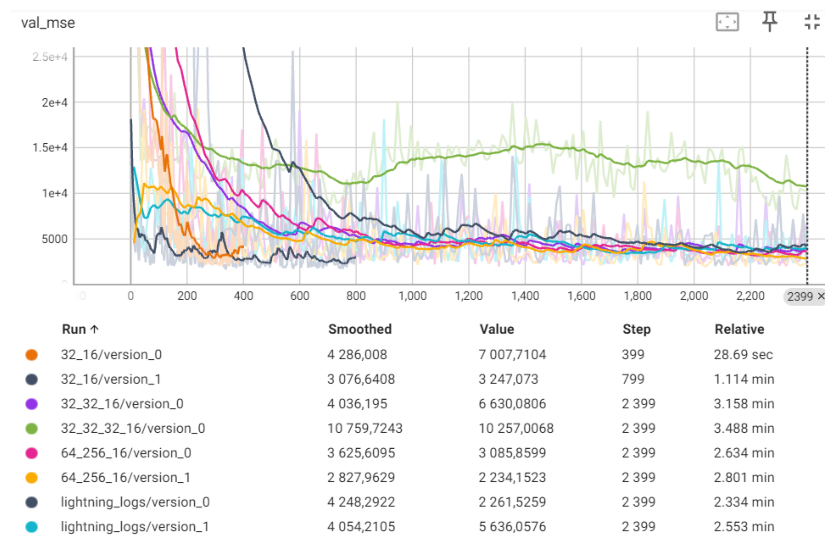

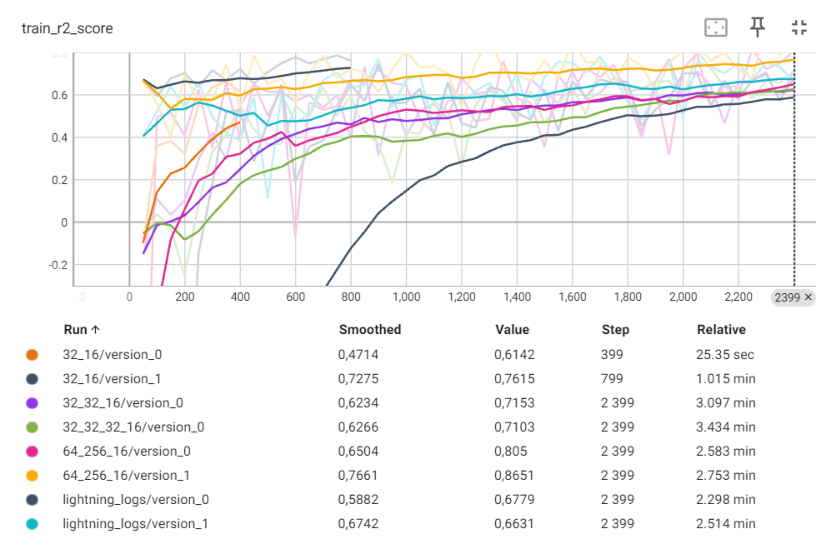

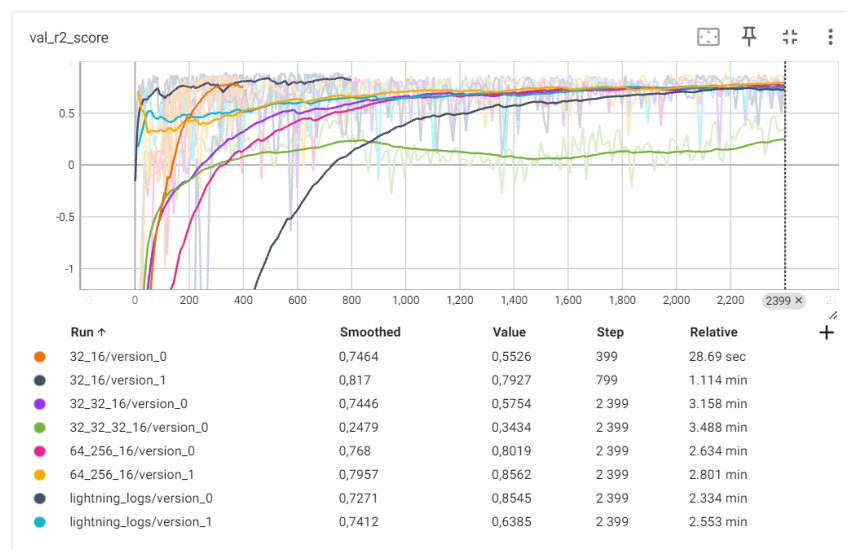

In [8]:
path = './Images/'
imgs = ['mse_val.png', 'r2train.png', 'r2val.png']
for img in imgs:
    img = path + img
    plt.figure(figsize=(15, 7))
    plt.imshow(plt.imread(img))
    plt.axis('off')

Даже после попыток применить все новые штуки, которым меня научили на другом предмете по машинному обучению, все равно не вышло получить `r2_score` выше 0.85. Это, быть может, чуть-чуть лучше линейной регрессии. В то время как полиномиальная лассо аппроксимация с хорошими гиперпараметрами дала результат $R_2 = 0.94$.

Чтобы улучшить ситуацию, для нейронной сети, вообще говоря, можно было бы тоже сделать преобразование над признаками. Помимо этого, как уже замечалось в прошлом ноутбуке, были определенные выбросы, избавление от которых, возможно могло немного улучшить ситуацию. Однако, хотелось попробровать реализовать все эти вещи хорошим выбором гиперпараметров, что не особо хорошо пока мне удается.

Также можно посмотреть на график $y_{test}(y_{pred})$

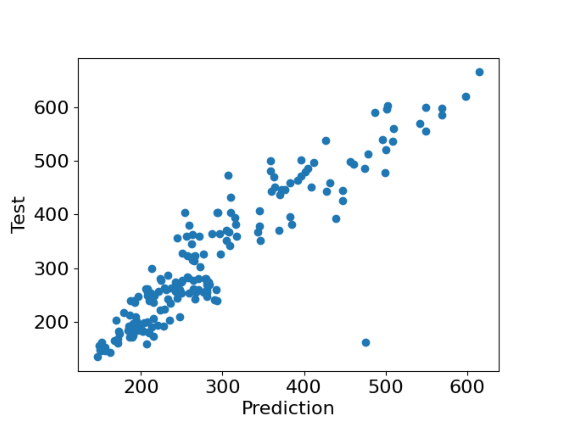

In [19]:
plt.figure(figsize=(7, 7))
plt.imshow(plt.imread('./Images/y_ypred (1).png'))
plt.axis('off');


В целом все хорошо, за исключением, уже до этого указанного выброса. Возможно, он меншал учится модели и, как минимум влиял на показания $R_2$